In [1]:
import sys
sys.path.append('../src')
from data import get_documents_list, get_cleaned_dataframe_with_topics
from models import classification, get_embedding_model, get_BERTopic_model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


loaded spacy language model: en_core_web_sm


load the preprocessed texts in all languages into a dataframe

In [2]:
df = get_cleaned_dataframe_with_topics()

Decide what types of documents you want to train your embedding model on

In [3]:
documents = get_documents_list('cleaned_texts_topics')

Document_list: [['Abel', '  Ehrlich', '  3', '  September', '  1915', '  Cranz', '  Ostpreußen', '  30', '  Oktober', '  2003', '  Tel', '  Aviv', '  war', '  ein', '  israelischer', '  Komponist', '  Ehrlich', '  aufgewachsen', '  einer', '  deutschen', '  jüdischen', '  Familie', '  floh', '  nach', '  dem', '  Abitur', '  Königsberg', '  1934', '  nach', '  Jugoslawien', '  er', '  studierte', '  der', '  Musikakademie', '  Zagreb', '  Komposition', '  und', '  Violine', '  bei', '  Vaclav', '  Huml', '  1938', '  emigrierte', '  er', '  über', '  Albanien', '  das', '  damalige', '  Palästina', '  ab', '  1939', '  studierte', '  er', '  Konservatorium', '  Jerusalem', '  bei', '  Emil', '  Hauser', '  Tzvi', '  Rothenberg', '  und', '  Solomon', '  Rosowski', '  Er', '  selbst', '  unterrichtete', '  danach', '  verschiedenen', '  Musikakademien', '  Jerusalem', '  und', '  Tel', '  Aviv', '  darunter', '  auch', '  von', '  1953', '  bis', '  1967', '  der', '  Kibbuzim', '  Hoch

Split data into train and test sets

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_texts'], df['label'] , test_size=0.3)

In [5]:
X_train

412    [Władysław,   Szpilman,   polish,   pronunciat...
226    [Franz,   Grothe,   17,   September,   1908,  ...
54     [Franz,   Ippisch,   18,   Juli,   1,   April,...
212    [Wladimir,   Rudolfowitsch,   Vogel,   russisc...
224    [Ernst,   Pepping,   12,   September,   1901, ...
                             ...                        
372    [Paul,   Aron,   bear,   4,   February,   2004...
230    [Gerhard,   Frommel,   7,   August,   1906,   ...
6      [Anton,   Webern,   3,   dezember,   1883,   W...
27     [Dawid,   Bajgelman,   oftmal,   auch,   David...
330    [Ignaz,   Friedman,   also,   spell,   Ignace,...
Name: cleaned_texts, Length: 312, dtype: object

## Word2Vec & fastText
### Parameters:
- vector_size - vector size
- window - num of words before and after the focus word considered as context for the word
- min_count - the number of times a word must appear in our corpus in order to create a word vector.

Train a Word2Vec model with the train set

In [7]:
model, word_vectors = get_embedding_model(documents, method = "fastText", text_type="cleaned_texts_topics")

fastText model not found.
Training new model on 446 documents.
Saving new model.
Model:  /home/Bachelor-Thesis/models/classification/FastText/FastText_en_cleaned_texts_topics  loaded


In [8]:
# Similarity of vectors for a word (useful for bilingual)
word_vectors.similarity('book', 'book')

1.0

## Text Classification on manually trained Embedding model

### Create features from text for machine learning model.
Steps:
- Turn words in texts into word vectors.
- Method 1: averaging word vectors for each text

In [9]:
X_train_vect = classification.text2vec(X_train, word_vectors)
X_test_vect = classification.text2vec(X_test, word_vectors)

In [10]:
X_train_vect_avg = classification.average_vector(X_train_vect)
X_test_vect_avg = classification.average_vector(X_test_vect)

### Classification reports:
- Recall = how many of this class where found over whole num of elements of this class
- Precision = how many correctly classified among that class
- f1-score: harmonic mean between precision and recall
- support: num of occurrence of given class in dataset

Instantiate and fit a basic Random Forest model on top of the vectors

In [11]:
y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "Random Forest")
classification.print_classification_report(y_test, y_pred)

y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "Multinomial Naive Bayes")
classification.print_classification_report(y_test, y_pred)

y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "SVM")
classification.print_classification_report(y_test, y_pred)

############################################################################
Processing Random Forest Classification

              precision    recall  f1-score   support

    verfolgt       0.97      0.87      0.91       128
    begnadet       0.11      0.33      0.16         6

    accuracy                           0.84       134
   macro avg       0.54      0.60      0.54       134
weighted avg       0.93      0.84      0.88       134

classes in y_pred: {0, 1} classes in y_test: {0, 1}
############################################################################
############################################################################
Processing Multinomial Naive Bayes Classification

              precision    recall  f1-score   support

    verfolgt       1.00      0.86      0.93       133
    begnadet       0.05      1.00      0.10         1

    accuracy                           0.87       134
   macro avg       0.53      0.93      0.51       134
weighted avg       0.99   

0    261
1     51
Name: label, dtype: int64


<AxesSubplot: ylabel='label'>

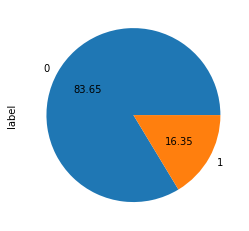

In [12]:
print(y_train.value_counts())
y_train.value_counts().plot.pie(autopct='%0.2f')

Highly Imbalanced Dataset!
Ideas:
- Undersampling: reduce majority class to make it equal to minority class
- Oversampling: increase minority class to make it equal to majority class through resampling
- K-fold cross validation

## Oversampling

In [13]:
!pip install imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy="not majority")
X_train_2d = X_train.values.reshape(-1, 1) # puts each elem of array in own array
X_res, y_res = ros.fit_resample(X_train_2d, y_train)

0    261
1    261
Name: label, dtype: int64


<AxesSubplot: ylabel='label'>

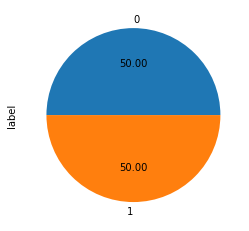

In [14]:
print(y_res.value_counts())
y_res.value_counts().plot.pie(autopct='%0.2f')

In [15]:
#X_res revert 2_dimensionality
X_res_1d = X_res.flatten()

# classification with resampled vectors
X_res_vect = classification.text2vec(X_res_1d, word_vectors)
X_res_vect_avg = classification.average_vector(X_res_vect)

In [17]:
y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "Random Forest")
classification.print_classification_report(y_test, y_res_pred)
y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "Multinomial Naive Bayes")
classification.print_classification_report(y_test, y_res_pred)
y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "SVM")
classification.print_classification_report(y_test, y_res_pred)

############################################################################
Processing Random Forest Classification

              precision    recall  f1-score   support

    verfolgt       0.93      0.86      0.90       124
    begnadet       0.11      0.20      0.14        10

    accuracy                           0.81       134
   macro avg       0.52      0.53      0.52       134
weighted avg       0.87      0.81      0.84       134

classes in y_pred: {0, 1} classes in y_test: {0, 1}
############################################################################
############################################################################
Processing Multinomial Naive Bayes Classification

              precision    recall  f1-score   support

    verfolgt       0.74      0.88      0.80        97
    begnadet       0.37      0.19      0.25        37

    accuracy                           0.69       134
   macro avg       0.55      0.53      0.53       134
weighted avg       0.64   

## Undersampling

In [18]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0, sampling_strategy="majority")
X_resampled, y_resampled = rus.fit_resample(X_train_2d, y_train)

0    51
1    51
Name: label, dtype: int64


<AxesSubplot: ylabel='label'>

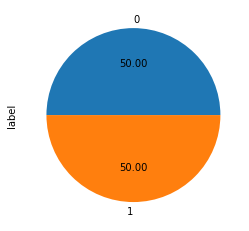

In [19]:
print(y_resampled.value_counts())
y_res.value_counts().plot.pie(autopct='%0.2f')

In [20]:
#X_res revert 2_dimensionality
X_resampled_1d = X_resampled.flatten()

# classification with resampled vectors
X_resampled_vect = classification.text2vec(X_resampled_1d, word_vectors)
X_resampled_vect_avg = classification.average_vector(X_resampled_vect)

In [21]:
y_resampled_pred = classification.classify_predict(X_resampled_vect_avg, X_test_vect_avg, y_resampled, "Random Forest")
classification.print_classification_report(y_test, y_resampled_pred)
y_resampled_pred = classification.classify_predict(X_resampled_vect_avg, X_test_vect_avg, y_resampled, "Multinomial Naive Bayes")
classification.print_classification_report(y_test, y_resampled_pred)
y_resampled_pred = classification.classify_predict(X_resampled_vect_avg, X_test_vect_avg, y_resampled, "SVM")
classification.print_classification_report(y_test, y_resampled_pred)

############################################################################
Processing Random Forest Classification

              precision    recall  f1-score   support

    verfolgt       0.51      0.89      0.65        66
    begnadet       0.63      0.18      0.28        68

    accuracy                           0.53       134
   macro avg       0.57      0.54      0.46       134
weighted avg       0.57      0.53      0.46       134

classes in y_pred: {0, 1} classes in y_test: {0, 1}
############################################################################
############################################################################
Processing Multinomial Naive Bayes Classification

              precision    recall  f1-score   support

    verfolgt       0.60      0.92      0.73        75
    begnadet       0.68      0.22      0.33        59

    accuracy                           0.61       134
   macro avg       0.64      0.57      0.53       134
weighted avg       0.64   